라이브러리 , 마운트
================================

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import keras
import keras.backend as K
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,shutil,cv2,glob

import pickle

Mounted at /content/drive


기본 데이터 정의
============

In [3]:
SEED = 909

#배치사이즈
BATCH_SIZE = 4

#에폭의 수
NUM_OF_EPOCHS = 50

#UNet 깊이
UNet_level = 5

#Train,Valid 비율
validation_ratio=0.2

#초기 피쳐의 수
initial_features = 32

#input channel
input_channels = 1

#백그라운드 포함 클래스 아웃풋 개수 (grayscale의 경우 1)
num_class=1

#원래(480,720) (이미지의 특징이 사라지지 않는 선에서 수정해도 상관없음) 
#원래(540,960)
IMAGE_HEIGHT = 400
IMAGE_WIDTH = 400
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = 'drive/MyDrive/data/'
data_dir_train = os.path.join(data_dir, 'slices/newtrain')
# 저장해야할 장소: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'img/img')
# 저장해야할 장소: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask/img')

data_dir_test = os.path.join(data_dir, 'slices/test')
# 저장해야할 장소: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'img')


출력함수
==============================

In [5]:
def applycolor(img,color):
  #클래스 이미지에 색 적용
  h,w,c = img.shape

  for i in range(h):
    for j in range(w):
      for k in range(c):
        img[i,j,k] = color[img[i,j,k]][k]

  return img

def display(display_list, opt=0):
  plt.figure(figsize=(15,15))
    
  title = [['Input Image', 'True Mask','Mixed Mask'],['Input Image', 'True Mask', 'Predicted Mask','Mixed Mask'],['Input Image', 'Predicted Mask','Mixed Mask']]
    
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[opt][i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
  plt.show()

def predict_img(img,get_last=False): 

  prediction = model.predict(img)

  if type(model.output) == list:
    num_of_output = len(model.output)
    x = prediction[num_of_output-1] if get_last else sum(prediction) / num_of_output
  else:
    x = prediction

  if num_class ==1:
    x= x[0]
    x[x>=0.5] = 1
    x[x<0.5] = 0
    x *= 255
  else:
    x = np.argmax(x[0], axis=-1) #해당픽셀의 채널 중에서 가장 큰 인덱스 값 가져옴 h,w
    x = np.expand_dims(x, axis=-1) #각 픽셀을단일로묶음 h,w,1
    x = x.astype(np.int32) #각 픽셀의 값을 int로 h,w,1
    x = np.concatenate([x, x, x], axis=2) #각픽셀 값을 3번 이어서 3채널로 만들어줌
    x = applycolor(x,c)

  return x


def display_dataset(ds,predict=False,num=1):
  i=0
  for x, y in ds:
    if i== num:
      break;
    display_list = []

    dx = x[0] * 255
    dx = dx.numpy()
    if num_class ==1:
      dy = y[0] * 255
      dy = dy.numpy()
    else :
      dy = np.argmax(y[0], axis=-1)
      dy = np.expand_dims(dy, axis=-1) #각 픽셀을단일로묶음 h,w,1
      dy = dy.astype(np.int32) #각 픽셀의 값을 int로 h,w,1
      dy = np.concatenate([dy, dy, dy], axis=2)
      dy = applycolor(dy,c)

    display_list.append(dx)
    display_list.append(dy)

    if predict:
      if input_channels == 1:
        p = predict_img(np.expand_dims(x[0], axis=0))
      else :
        p = predict_img(x[0])
      display_list.append(p)

    if num_class == 1:
      display_list.append(np.expand_dims(cv2.addWeighted(dx, 1, display_list[predict+1], 0.5,0),axis=-1))
    else:
      display_list.append(cv2.addWeighted(dx.astype(np.int32), 1, display_list[predict+1], 0.5,0))
    
    display(display_list,predict)
    i+=1

def display_test(files,num=1):
  for i in range(num):
    display_list = []
    x = read_image(files[i]) 
    dx = x*255
    
    if input_channels == 1:
      p = predict_img(np.expand_dims(x, axis=0))
    else:
      p = predict_img(x)
    
    display_list.append(dx)
    display_list.append(p)

    if num_class == 1:
      display_list.append(np.expand_dims(cv2.addWeighted(dx, 1, p, 0.5,0),axis=-1))
    else:
      display_list.append(cv2.addWeighted(display_list[0].astype(np.int32), 1, p, 0.5,0))
    display(display_list,2)

#model 학습 정보 표시,저장
def display_history(history, dir, num,save_pic=True,save_csv=True,save_best_infor=True):
  t = ['Accuracy','Loss']
  k = ['accuracy','loss']
  p = ['lower','upper']


  if type(model.output) != list : num_of_output = 1
  else: num_of_output = len(model.output)

  plt.figure(figsize=(24,3*num_of_output))

  for i in range(num_of_output):

    if type(model.output) != list : name = ''
    else: name = model.output_names[i]+'_'

    for j in range(4):
      plt.subplot(num_of_output,4,i*4+j+1)
      if j%2==0 :
        plt.plot(history[f'{name}{k[j//2]}'], 'g-', label= k[j//2])
        if i==0:
          plt.title(t[j//2])
      else :
        plt.plot(history[f'val_{name}{k[j//2]}'], 'g-', label= 'val_'+k[j//2])
        if i==0:
          plt.title('Val_'+t[j//2])
      if j==0:
        plt.ylabel(f'Output[{i}]')
      elif i== num_of_output-1 :
        plt.xlabel('Epoch')
      plt.legend(loc= p[j//2]+' right')
      plt.grid(True, axis='both',alpha=0.5)

  if (save_pic) : 
    plt.savefig(f'{dir}/Graph{num}.png')

  if (save_csv):
    hist_df = pd.DataFrame(history) 
    with open(f'{dir}/History{num}.csv', mode='w') as f:
      hist_df.to_csv(f)

  if (save_best_infor):
    idx = np.argmin(history['val_loss'])
    result = [['Epoch'],[idx+1]]
    start_idx = 1-(type(history) == dict)
    for i in range(start_idx,len(history.keys())):
      key = list(history.keys())[i]
      result[0].append(key)
      result[1].append(history[key][idx])
    hist_df = pd.DataFrame(result) 
    with open(f'{dir}/Best{num}.Infor.csv', mode='w') as f:
      hist_df.to_csv(f)
      
  plt.show()

데이터 전처리
====================

In [6]:

def read_image(path):
  if input_channels == 1:
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1) #grayscale의 경우 추가 아니면 그냥 삭제
  else:
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT))
    x = x / 255.0
  x = x.astype(np.float32)
  return x

def read_mask(path):
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT))

  if num_class == 1:
    x = x / 255.0 #이미지가 1 2 3으로 구성되면 필요 x
    x = np.expand_dims(x, axis=-1) #onehotencode를 나중에 하게 된다면 필요없음
    x = x.astype(np.float32)
  else :
    x = x.astype(np.int32)
  return x

def tf_dataset(x, y, batch_size=1):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.shuffle(buffer_size=1000)
  dataset = dataset.map(preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

def preprocess(x, y):
  def f(x, y):
    x = x.decode()
    y = y.decode()

    x = read_image(x)
    y = read_mask(y)

    return x, y

  if (num_class==1):
    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
  else:
    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_class, dtype=tf.int32)
  image.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, input_channels])
  mask.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, num_class])

  return image, mask

train_x = sorted(glob.glob(os.path.join(data_dir_train_image, '*')))
train_y = sorted(glob.glob(os.path.join(data_dir_train_mask, '*')))

train_x, valid_x = train_test_split(train_x, test_size=validation_ratio, random_state=SEED)
train_y, valid_y = train_test_split(train_y, test_size=validation_ratio, random_state=SEED)


print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=BATCH_SIZE)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=BATCH_SIZE)


Dataset: Train: 448 - Valid: 112


In [8]:
NUM_TRAIN = len(train_x)

NUM_VALID = len(valid_x)

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE
EPOCH_STEP_VALID = NUM_VALID // BATCH_SIZE

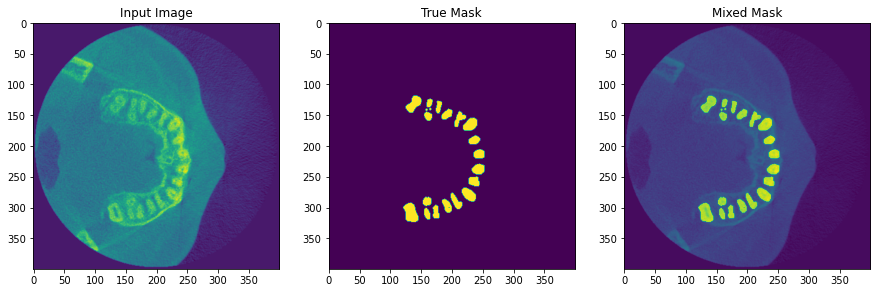

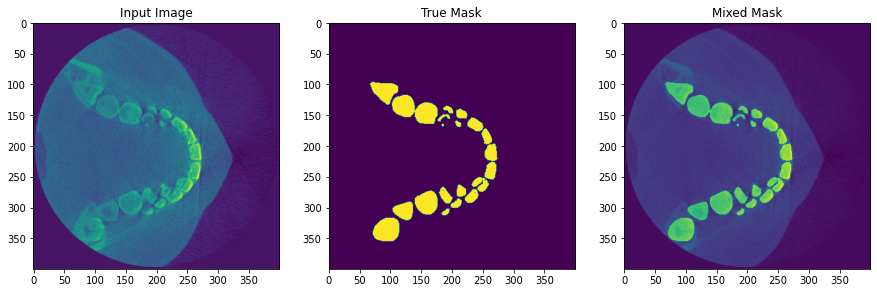

In [9]:
display_dataset(train_dataset,False,2)

사용자 정의 손실함수
================================

In [10]:
def DiceBCELoss(y_true, y_pred,smooth=1e-5):    
    
    y_true_f= K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    BCE =  tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f)
    intersection = K.sum(y_true_f * y_pred_f, axis=-1)
    dice_loss = 1 - (2 * intersection + smooth) / (K.sum(y_true_f,-1) + K.sum(y_pred_f,-1) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE
    
def IoULoss(y_true, y_pred, smooth=1e-6):

    y_pret_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    
    intersection = K.sum(y_true_f* y_pret_f)
    total = K.sum(y_true_f) + K.sum(y_pret_f)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU

# 0.5 4/3

# 0.8 2.0
def FocalLoss(y_true, y_pred, alpha=1.0, gamma=2.0):    
    
    y_pret_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    
    BCE = K.binary_crossentropy(y_true_f, y_pret_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def Focal_IoU(y_true, y_pred):
  return FocalLoss(y_true,y_pred) + IoULoss(y_true, y_pred)

custom_loss = {'DiceBCELoss': DiceBCELoss,'Focal_IoU':Focal_IoU}

layer U-Net
==========================

In [ ]:
def conv(input,features,kernel_size=3,strides = 1,padding='same',is_relu=True,is_bn=False):
  x= keras.layers.Conv2D(features,kernel_size,strides,padding)(input)
  if is_bn:
    x = keras.layers.BatchNormalization()(x)
  if is_relu:
    x = keras.activations.relu(x)
  return x

def layerUNET(n_levels,DSV=True ,initial_features=initial_features, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=input_channels, out_channels=num_class):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs

    skips = []
    for _ in range(n_levels):
      skips.append(list())

    #인코더부분
    for level in range(n_levels):
      if level != 0 :
        x = keras.layers.MaxPool2D(pooling_size)(x)
      for _ in range(n_blocks):
        x = conv(x,initial_features * 2 ** level,3,1,'same')
      skips[level].append(x)

    #스킵 생성 부분
    for i in range(1,n_levels):
      for level in range(n_levels-i):
        list_concat = []

        #같은 레벨
        tmp = []
        for j in range(i):
          tmp.append(conv(skips[level][j],initial_features,3,1,'same'))
        if (len(tmp)>1):
          x = keras.layers.concatenate(tmp)
        else :
          x = tmp[0]
        x = conv(x,initial_features,3,1,'same')
        list_concat.append(x)

        #위  레벨
        for row in range(level):
          x = keras.layers.MaxPool2D(pooling_size**(level-row),pooling_size**(level-row))(skips[row][0])
          x = conv(x,initial_features,3,1,'same')
          list_concat.append(x)
        
        #아래 레벨
        for j in range(i):
          x = keras.layers.UpSampling2D(pooling_size**(j+1), interpolation='bilinear')(skips[level+j+1][i-j-1])
          x = conv(x,initial_features,3,1,'same')
          list_concat.append(x)
        

        #Concatenate 부분
        x = keras.layers.concatenate(list_concat)
        for _ in range(1): 
          x = conv(x,initial_features * len(list_concat),3,1,'same',is_bn= True)
        skips[level].append(x)
    
    # 출력부분
    result = []
    
    if DSV:
      for i in range(1,n_levels):
        x = conv(skips[0][i],out_channels,1,1,'same',False,False)
        result.append(x)

      for i in range(1,n_levels):
        x = conv(skips[i][-1],out_channels,3,1,'same',False,False)
        x = keras.layers.UpSampling2D(pooling_size**(i), interpolation='bilinear')(x)
        result.append(x)
    else:
      result.append(x = conv(skips[0][-1],out_channels,1,1,'same',False,False))
    
    for i in range(len(result)):
      if out_channels == 1:
        result[i] = keras.activations.sigmoid(result[i])
      else:
        result[i] = keras.activations.softmax(result[i])

    output_name=f'LayerUNET-L{n_levels}-F{initial_features}'

    if DSV:
      output_name+=f'-DSV'

    return keras.Model(inputs=[inputs], outputs=result, name=output_name)

model = layerUNET(UNet_level,True)

모델 요약
=====================

In [ ]:
model.summary()

학습+예측 이미지
=========================

In [ ]:
model.compile(optimizer='adam', loss=Focal_IoU, metrics=['accuracy'])
print(model.name,"모델이 컴파일 되었습니다.")
if (os.path.exists(f'{data_dir}/{model.name}.h5')):
  print('해당모델과 같은 이름의 모델이 학습되고 있습니다.')
if (os.path.exists(f'/content/drive/MyDrive/data/model/{model.name}-H{IMAGE_HEIGHT}-W{IMAGE_WIDTH}-{BATCH_SIZE}')):
  print('해당모델과 같은 이름의 모델이 이전에 학습된 적이 있습니다.')
print('Model Outputs :' , model.output_names)

In [ ]:
#학습부분
print(f'Train Data:{NUM_TRAIN}')
print(f'Valid Data:{NUM_VALID}')
print(f'Epochs:{NUM_OF_EPOCHS}')
print(f'Batch Size:{BATCH_SIZE}')
print(f'U-NET Level:{UNet_level}')
print(f'Model Name:{model.name}')
print(f'Loss:{model.loss}')
print(f'Dataset Name:{data_dir.split("/")[-1]}')
print(f'I/O Image Size (H * W):{IMAGE_HEIGHT} * {IMAGE_WIDTH}')

cp_dir = f'{data_dir}/{model.name}.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath=cp_dir, 
                                        save_best_only=True,
                                        verbose=1
                                        )

history = model.fit(train_dataset,
                    steps_per_epoch=EPOCH_STEP_TRAIN,
                    validation_data=valid_dataset,
                    validation_steps=EPOCH_STEP_VALID,
                    epochs=NUM_OF_EPOCHS,
                    callbacks=[mc]
                    )


/content/drive/MyDrive/data/model/EUNET-L5-F32-H400-W400-4에 1번째 모델이 저장 되었습니다.


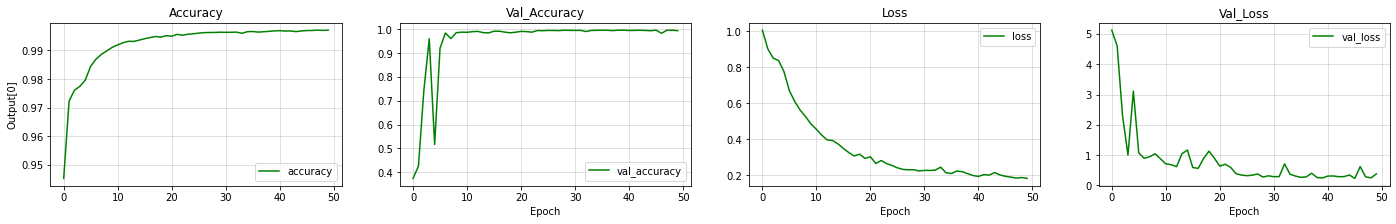

In [26]:
save_dir = f'/content/drive/MyDrive/data/model/{model.name}-H{IMAGE_HEIGHT}-W{IMAGE_WIDTH}-{BATCH_SIZE}'

if os.path.exists(save_dir) == False:
  os.makedirs(save_dir)

new_model_num = 1
while (os.path.exists(f'{save_dir}/Model{new_model_num}.h5')):
  new_model_num += 1

model.save(f'{save_dir}/Model{new_model_num}.h5')
if os.path.exists(cp_dir):
  shutil.move(cp_dir,f'{save_dir}/Best{new_model_num}.h5')
print(f'{save_dir}에 {new_model_num}번째 모델이 저장 되었습니다.')
display_history(history.history,save_dir,new_model_num,True,True,True)

In [ ]:
display_dataset(train_dataset,True,num=20)

In [ ]:
test_x = glob.glob(os.path.join(data_dir_test_image, 'tooth4*'))
display_test(test_x,len(test_x))

모델 불러오기
=========================

In [ ]:
# 이전에 컴파일 한 모델 불러오기
load_dir = '/content/drive/MyDrive/data/model/UNET3-L5-F32-DSV-H400-W400-2'
model_num =1

sel_best = False
model_name = ''

if sel_best == True: 
  model_name = 'Best' 
else :
  model_name = 'Model'

model = tf.keras.models.load_model(f'/content/drive/MyDrive/data/model/LayerUNET-1conv-opt2-L5-F32-DSV-H400-W400-4/Model5.h5',custom_objects= custom_loss)
#model = tf.keras.models.load_model(f'{load_dir}/{model_name}{model_num}.h5',custom_objects= custom_loss)
#history = pd.read_csv(f'{load_dir}/History{model_num}.csv')
#display_history(history,load_dir,model_num,True,False,True) 